# Data Import

In [2]:
### Imports the whole etch_roof_d3s sheet, which is quite memory-intensive

import pandas
df_full=pandas.read_csv(('etch_roof_d3s.csv'))
df_full

,deviceTime_utc,deviceTime_local,deviceTime_unix,cpm,cpmError,keV_per_ch,0,1,2,3,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,error_flag
0,2017-03-15 20:50:59+00:00,2017-03-15 13:50:59-07:00,1489611059,2121.6,20.599029,2.50,0,0,0,0,...,0,0,0,0,0,0,0,0,71,NaN
1,2017-03-15 20:55:59+00:00,2017-03-15 13:55:59-07:00,1489611359,2149.8,20.735477,2.50,0,0,0,0,...,0,0,0,0,0,0,0,0,55,NaN
2,2017-03-15 21:01:00+00:00,2017-03-15 14:01:00-07:00,1489611660,2192.2,20.938959,2.50,0,0,0,0,...,0,0,0,1,0,0,0,0,61,NaN
3,2017-03-15 21:14:54+00:00,2017-03-15 14:14:54-07:00,1489612494,2145.8,20.716177,2.50,0,0,0,0,...,0,0,0,0,0,1,0,0,78,NaN
4,2017-03-15 21:19:54+00:00,2017-03-15 14:19:54-07:00,1489612794,2119.6,20.589318,2.50,0,0,0,0,...,1,0,0,0,0,0,0,0,78,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218286,2020-10-17 00:07:44+0000,10/16/2020 17:07,1602893264,2352.6,21.691473,2.57,0,0,0,0,...,0,1,0,0,0,0,0,0,63,0.0
218287,2020-10-17 00:12:44+0000,10/16/2020 17:12,1602893564,2307.6,21.483017,2.57,0,0,0,0,...,0,0,0,0,0,0,0,0,62,0.0
218288,2020-10-17 00:17:44+0000,10/16/2020 17:17,1602893864,2322.6,21.552726,2.57,0,0,0,0,...,0,0,0,0,0,0,0,0,59,0.0
218289,2020-10-17 00:22:44+0000,10/16/2020 17:22,1602894164,2344.2,21.652713,2.57,0,0,0,0,...,0,0,0,0,0,0,0,0,58,0.0


In [3]:
### Importing temperature data from .csv file, change values in "columns" if more/different data is needed
## Only needs to be run once for any number of time ranges being evaluated

columns = ['deviceTime_local','deviceTime_unix','temperature']
import pandas as pd
Tdf = pd.read_csv('etch_roof_weather.csv',usecols=columns)
Tdf

,deviceTime_local,deviceTime_unix,temperature
0,2017-11-17 10:40:49-08:00,1510944049,17.57
1,2017-11-17 10:45:49-08:00,1510944349,17.04
2,2017-11-17 10:50:49-08:00,1510944649,16.58
3,2017-11-17 10:55:49-08:00,1510944949,16.39
4,2017-11-17 11:00:49-08:00,1510945249,16.20
...,...,...,...
219885,4/23/2021 16:10,1619219439,14.54
219886,4/23/2021 16:15,1619219739,14.19
219887,4/23/2021 16:20,1619220039,14.87
219888,4/23/2021 16:25,1619220339,14.92


# Run for whole data set (will take quite a while to run)

In [4]:
### Finding the length of the data set (# of hours that exist between the first and last points)

begin = Tdf.loc[0,'deviceTime_unix']
end = df_full.loc[218290,'deviceTime_unix']
diff = round((end-begin)/3600)
diff

25542

In [5]:
### WINTER MONTH (February)


### Fits the radiation counts using a Gaussian + polynomial fit
## Current Settings: 2nd order polynomial (quadratic), peak range of 600-650 keV, std dev max of 20 keV
## Time range of this cell: 8/6-9/5/19 (midnight to midnight, exactly 1 month)
## Expected runtime: ~2 min

# If changing the timescale, the following variables must be redefined appropriately:
# df_month (which slice of df_full is taken), radon_count (should be total number of hours in chosen set), start (convert to unix)
# All other parts of the code should execute properly regardless of the size of the set, though runtime may increase greatly

import pandas as pd
from scipy.signal import find_peaks as fp
import numpy as np
from scipy.optimize import curve_fit

### Creating a dataframe of exactly a month of collected data
col = ['deviceTime_utc','cpmError','1023','error_flag']
df_trim = df_full.reset_index().drop(columns=col) # 
radon_count = np.zeros(diff) # creating an empty dataframe to add hourly radon counts to
total_count = np.zeros(diff) # creating an empty dataframe to add hourly averaged gamma counts to
start = 1510941600 # Setting a baseline time for the loop to start from (in this case it is 12:00:00 Local Time 11/15/18)
end = start

for i in range(0,diff):
    #start = df_month.at[i,'deviceTime_unix']-10 ####### change out the zero for the current for loop index
    #end = start + 3600
    
    ### Sets an hour range for the data, and selecting those rows
    start = end #setting start time based on current index
    end = start + 3600 # end time falls 1 hour after the start time
    hour_set = df_trim['deviceTime_unix'].between(start,end) # Boolean output of rows which fall between start and end times
    hour = df_trim[hour_set].drop(columns=['index','deviceTime_local','deviceTime_unix'])#.sum(axis=0)

    ### Grabs the total counts and puts it into a separate dataframe
    total_count[i] = hour['cpm'].mean()
    
    ### Finding the mean energy per channel from the input, and setting the appropriate energies as column names
    channel_energy = hour['keV_per_ch'].mean(axis=0)
    hour = hour.drop(columns=['cpm','keV_per_ch'])
    col_energy = np.linspace(0,1022*channel_energy,1023)
    hour.columns = col_energy

    ### Taking the mean # of counts for each column (now an energy band)
    hour = hour.mean(axis=0)
    hour1 = pd.DataFrame({'Lower Energy Bounds':hour.index})
    hour2 = pd.DataFrame({'Mean counts':hour}).reset_index(drop=True)
    hour = pd.concat([hour1,hour2],axis=1) # creates a dataframe for the hour, including the energy threshold for each channel and its corresponding counts
    hour = hour.dropna() # drops any empty rows from the dataframe
    if hour.empty==True: # If the dataframe is now empty, there is no spectrum to observe, go to the next hour
        continue

    ### Need to find the peak using the appropriate energy value, not an index
    peak_bounds = hour.iloc[(hour['Lower Energy Bounds']-609.3).abs().argsort()[:2]] # finds the two closest rows to 609.3 keV in energy
    peak_id = peak_bounds.index.sort_values()[0] # outputs the index (channel) that the peak (609.3 keV) is contained in

    ### Sets the window to find the peak based on the peak energy
    window_start = peak_id-80
    window_end = peak_id+80
    window = np.linspace(window_start,window_end,161)
    window_energies = hour.iloc[window_start:window_end+1,0]
    window_counts = hour.iloc[window_start:window_end+1,1]

    ### Defining a combined function of a gaussian and a polynomial, and fitting it to the data
    def gaussian(x,amp,cen,sig):
        return amp*np.exp(-(x-cen)**2/(2*sig**2))
    def gaussian_plus_polynomial(x,amp,cen,sig,a,b,c): 
        return amp*np.exp(-(x-cen)**2/(2*sig**2)) + a*x**2 + b*x + c
    popt,_ = curve_fit(gaussian_plus_polynomial,window_energies,window_counts,bounds =([0,600,0,-1000,-1000,-1000] ,[1000,650,20,1000,0,1000]))
    popt_gaus = popt[0:3]
    popt

    ### Finding the average radon cpm for the hour, adding to overall array
    predicted = gaussian_plus_polynomial(window_energies,*popt)
    radon_count[i] = gaussian(window_energies,*popt_gaus).sum()
    #if i==350:
        #break

In [6]:
### Creates an dataframe of date and time to align counts and temperatures with (purely for readability, is not used in plotting at all)

import time
import numpy as np
import pandas as pd

current_time = 1510938000 # 11:00 PM on 2/1/18
dates = []
hour = []
    
for i in range(0,diff):
    current_time = current_time + 3600
    time1 = time.localtime(current_time) 
    
    year = str(time1[0])
    month = str(time1[1])
    day = str(time1[2])
    
    date_string = [month,day,year]
    #test_string
    dates.append('-'.join(date_string))
    hour.append(time1[3])
    
temp_date = pd.DataFrame({'Date':dates})
temp_hour = pd.DataFrame({'Hour':hour})
DS = pd.concat([temp_date,temp_hour],axis=1)

In [7]:
### Turns Radon outputs into a dataframe, and concatenates with the overall data set
import pandas as pd

Output_Data = pd.DataFrame({'Radon Counts':radon_count})
Output2 = pd.DataFrame({'Total Counts':total_count})
DS = pd.concat([DS,Output_Data,Output2],axis=1)

In [8]:
### Gathering appropriate average temperatures and concatenates with overall dataframe

import pandas as pd
import numpy as np

#T_feb = Tdf[128:7939].reset_index(drop=True)

T_zeros = np.zeros(diff)
T_temp = pd.DataFrame({'Temperature':T_zeros})

T_start = 1510941600
T_end = T_start

for j in range(0,diff):
    T_start = T_end
    T_end = T_start + 3600
    
    T_bool = Tdf['deviceTime_unix'].between(T_start,T_end)
    if T_bool.loc[T_bool==True].empty:
        T_temp.iloc[j,0] = 0
        continue
    T_hourly = Tdf[T_bool].drop(columns=['deviceTime_local','deviceTime_unix'])
    T_temp.iloc[j,0] = T_hourly.mean()

DS = pd.concat([DS,T_temp],axis=1)

In [9]:
### Dropping out any rows that have a zero value for temperature or radon counts

DS_final = DS
Radon_nonzero = (DS_final['Radon Counts'] > 0) # Boolean output of the rows that have positive values for radon count
DS_final = DS_final[Radon_nonzero] # Removes rows with a zero value for radon count
#Radon_negative = (Data_set_final['Radon Counts'] > 0)
#Data_set_final = Data_set_final[Radon_negative]
Temperature_nonzero = (DS_final['Temperature'] != 0) # same idea as Radon_nonzero, but now for temperature
DS_final = DS_final[Temperature_nonzero] # Removes any additional rows that have a 0 value for temperature
#Total_nonzero = (DS_final_Feb['Total Counts'] != 0) These rows shouldn't be necessary since any zeros would be in the same rows as radon counts
#DS_final_Feb = DS_final_Feb[Total_nonzero]

In [10]:
### Checking that the above cell worked properly, not necessary to run every time

(DS_final == 0).sum()

Date              0
Hour            598
Radon Counts      0
Total Counts      0
Temperature       0
dtype: int64

# Stat Analysis

In [12]:
### Finding various stat parameters of the data set

from scipy import stats
import numpy as np
x = DS_final['Temperature'].to_numpy()
y = DS_final['Radon Counts'].to_numpy()
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(slope,r_value**2,p_value)

0.19685446653751199 0.01319403349189753 2.892302515230005e-42


# OLDER CODE, MONTHLY BASIS

# Fall Month

In [3]:
### Late summer month (Aug-Sep)

### Fits the radiation counts using a Gaussian + polynomial fit
## Current Settings: 2nd order polynomial (quadratic), peak range of 600-650 keV, std dev max of 20 keV
## Time range of this cell: 8/6-9/5/19 (midnight to midnight, exactly 1 month)
## Expected runtime: ~2 min

# If changing the timescale, the following variables must be redefined appropriately:
# df_month (which slice of df_full is taken), radon_count (should be total number of hours in chosen set), start (convert to unix)
# All other parts of the code should execute properly regardless of the size of the set, though runtime may increase greatly

import pandas as pd
from scipy.signal import find_peaks as fp
import numpy as np
from scipy.optimize import curve_fit

### Creating a dataframe of exactly a month of collected data
col = ['deviceTime_utc','cpm','cpmError','1023','error_flag']
df_fall = df_full[182138:190991].reset_index().drop(columns=col) # takes exactly a month, from 12:01 AM 8/6/19 to 11:59 PM 9/5/19 (local time)
radon_count_fall = np.zeros(744) # creating an empty dataframe to add hourly radon counts to
start = 1565074800 # Setting a baseline time for the loop to start from (in this case it is 12:00:00 Local Time 8/6/19)
end = start

for i in range(0,24*31):
    # Will eventually become a for loop, with an iteration for each hour
    #start = df_month.at[i,'deviceTime_unix']-10 ####### change out the zero for the current for loop index
    #end = start + 3600
    
    ### Sets an hour range for the data, and selecting those rows
    start = end #setting start time based on current index
    end = start + 3600 # end time falls 1 hour after the start time
    hour_set = df_fall['deviceTime_unix'].between(start,end) # Boolean output of rows which fall between start and end times
    hour = df_fall[hour_set].drop(columns=['index','deviceTime_local','deviceTime_unix'])#.sum(axis=0)

    ### Finding the mean energy per channel from the input, and setting the appropriate energies as column names
    channel_energy = hour['keV_per_ch'].mean(axis=0)
    hour = hour.drop(columns='keV_per_ch')
    col_energy = np.linspace(0,1022*channel_energy,1023)
    hour.columns = col_energy

    ### Taking the mean # of counts for each column (now an energy band)
    hour = hour.mean(axis=0)
    hour1 = pd.DataFrame({'Lower Energy Bounds':hour.index})
    hour2 = pd.DataFrame({'Mean counts':hour}).reset_index(drop=True)
    hour = pd.concat([hour1,hour2],axis=1) # creates a dataframe for the hour, including the energy threshold for each channel and its corresponding counts
    hour = hour.dropna() # drops any empty rows from the dataframe
    if hour.empty==True: # If the dataframe is now empty, there is no spectrum to observe, go to the next hour
        continue

    ### Need to find the peak using the appropriate energy value, not an index
    peak_bounds = hour.iloc[(hour['Lower Energy Bounds']-609.3).abs().argsort()[:2]] # finds the two closest rows to 609.3 keV in energy
    peak_id = peak_bounds.index.sort_values()[0] # outputs the index (channel) that the peak (609.3 keV) is contained in

    ### Sets the window to find the peak based on the peak energy
    window_start = peak_id-80
    window_end = peak_id+80
    window = np.linspace(window_start,window_end,161)
    window_energies = hour.iloc[window_start:window_end+1,0]
    window_counts = hour.iloc[window_start:window_end+1,1]

    ### Defining a combined function of a gaussian and a polynomial, and fitting it to the data
    def gaussian(x,amp,cen,sig):
        return amp*np.exp(-(x-cen)**2/(2*sig**2))
    def gaussian_plus_polynomial(x,amp,cen,sig,a,b,c): 
        return amp*np.exp(-(x-cen)**2/(2*sig**2)) + a*x**2 + b*x + c
    popt,_ = curve_fit(gaussian_plus_polynomial,window_energies,window_counts,bounds =([0,600,0,-1000,-1000,-1000] ,[1000,650,20,1000,0,1000]))
    popt_gaus = popt[0:3]
    popt

    ### Finding the average radon cpm for the hour, adding to overall array
    predicted = gaussian_plus_polynomial(window_energies,*popt)
    radon_count_fall[i] = gaussian(window_energies,*popt_gaus).sum()
    #if i==75:
        #break

KeyboardInterrupt: 

In [ ]:
### Creates an dataframe of date and time to align counts and temperatures with (purely for readability, is not used in plotting at all)

import time
import numpy as np
import pandas as pd

current_time = 1565071200 # 11:00 PM on 8/5/19
dates = []
hour = []
    
for i in range(0,24*31):
    current_time = current_time + 3600
    time1 = time.localtime(current_time) 
    
    year = str(time1[0])
    month = str(time1[1])
    day = str(time1[2])
    
    date_string = [month,day,year]
    #test_string
    dates.append('-'.join(date_string))
    hour.append(time1[3])
    
temp_date = pd.DataFrame({'Date':dates})
temp_hour = pd.DataFrame({'Hour':hour})
Data_set_fall = pd.concat([temp_date,temp_hour],axis=1)

In [ ]:
### Turns Radon outputs into a dataframe, and concatenates with the overall data set
import pandas as pd

Output_Data = pd.DataFrame({'Radon Counts':radon_count_fall})
Data_set_fall = pd.concat([Data_set_fall,Output_Data],axis=1)

In [ ]:
### Gathering appropriate average temperatures and concatenating with overall dataframe

import pandas as pd
import numpy as np

T_fall = Tdf[137772:144142].reset_index(drop=True)

T_zeros = np.zeros(744)
T_temp = pd.DataFrame({'Temperature':T_zeros})

T_start = 1565074800
T_end = T_start

for j in range(0,24*31):
    T_start = T_end
    T_end = T_start + 3600
    
    T_bool = T_fall['deviceTime_unix'].between(T_start,T_end)
    if T_bool.loc[T_bool==True].empty:
        T_temp.iloc[j,0] = 0
        continue
    T_hourly = T_fall[T_bool].drop(columns=['deviceTime_local','deviceTime_unix'])
    T_temp.iloc[j,0] = T_hourly.mean()

Data_set_fall = pd.concat([Data_set_fall,T_temp],axis=1)

In [ ]:
### Dropping out any rows that have a zero value for temperature or radon counts

DS_final_fall = Data_set_fall
Radon_nonzero_fall = (DS_final_fall['Radon Counts'] > 0) # Boolean output of the rows that have positive values for radon count
DS_final_fall = DS_final_fall[Radon_nonzero_fall] # Removes rows with a zero value for radon count
#Radon_negative = (Data_set_final['Radon Counts'] > 0)
#Data_set_final = Data_set_final[Radon_negative]
Temperature_nonzero = (DS_final_fall['Temperature'] != 0) # same idea as Radon_nonzero, but now for temperature
DS_final_fall = DS_final_fall[Temperature_nonzero] # Removes any additional rows that have a 0 value for temperature

In [ ]:
### Checking that the above cell worked properly, not necessary to run every time

(DS_final_fall == 0).sum()

# Winter Month

In [ ]:
### WINTER MONTH (February)


### Fits the radiation counts using a Gaussian + polynomial fit
## Current Settings: 2nd order polynomial (quadratic), peak range of 600-650 keV, std dev max of 20 keV
## Time range of this cell: 8/6-9/5/19 (midnight to midnight, exactly 1 month)
## Expected runtime: ~2 min

# If changing the timescale, the following variables must be redefined appropriately:
# df_month (which slice of df_full is taken), radon_count (should be total number of hours in chosen set), start (convert to unix)
# All other parts of the code should execute properly regardless of the size of the set, though runtime may increase greatly

import pandas as pd
from scipy.signal import find_peaks as fp
import numpy as np
from scipy.optimize import curve_fit

### Creating a dataframe of exactly a month of collected data
col = ['deviceTime_utc','cpm','cpmError','1023','error_flag']
df_feb = df_full[157273:164924].reset_index().drop(columns=col) # takes exactly a month, from 12:01 AM 2/1/19 to 11:59 PM 2/28/19 (local time)
radon_count_feb = np.zeros(672) # creating an empty dataframe to add hourly radon counts to
start = 1549008000 # Setting a baseline time for the loop to start from (in this case it is 12:00:00 Local Time 2/1/19)
end = start

for i in range(0,672):
    #start = df_month.at[i,'deviceTime_unix']-10 ####### change out the zero for the current for loop index
    #end = start + 3600
    
    ### Sets an hour range for the data, and selecting those rows
    start = end #setting start time based on current index
    end = start + 3600 # end time falls 1 hour after the start time
    hour_set = df_feb['deviceTime_unix'].between(start,end) # Boolean output of rows which fall between start and end times
    hour = df_feb[hour_set].drop(columns=['index','deviceTime_local','deviceTime_unix'])#.sum(axis=0)

    ### Finding the mean energy per channel from the input, and setting the appropriate energies as column names
    channel_energy = hour['keV_per_ch'].mean(axis=0)
    hour = hour.drop(columns='keV_per_ch')
    col_energy = np.linspace(0,1022*channel_energy,1023)
    hour.columns = col_energy

    ### Taking the mean # of counts for each column (now an energy band)
    hour = hour.mean(axis=0)
    hour1 = pd.DataFrame({'Lower Energy Bounds':hour.index})
    hour2 = pd.DataFrame({'Mean counts':hour}).reset_index(drop=True)
    hour = pd.concat([hour1,hour2],axis=1) # creates a dataframe for the hour, including the energy threshold for each channel and its corresponding counts
    hour = hour.dropna() # drops any empty rows from the dataframe
    if hour.empty==True: # If the dataframe is now empty, there is no spectrum to observe, go to the next hour
        continue

    ### Need to find the peak using the appropriate energy value, not an index
    peak_bounds = hour.iloc[(hour['Lower Energy Bounds']-609.3).abs().argsort()[:2]] # finds the two closest rows to 609.3 keV in energy
    peak_id = peak_bounds.index.sort_values()[0] # outputs the index (channel) that the peak (609.3 keV) is contained in

    ### Sets the window to find the peak based on the peak energy
    window_start = peak_id-80
    window_end = peak_id+80
    window = np.linspace(window_start,window_end,161)
    window_energies = hour.iloc[window_start:window_end+1,0]
    window_counts = hour.iloc[window_start:window_end+1,1]

    ### Defining a combined function of a gaussian and a polynomial, and fitting it to the data
    def gaussian(x,amp,cen,sig):
        return amp*np.exp(-(x-cen)**2/(2*sig**2))
    def gaussian_plus_polynomial(x,amp,cen,sig,a,b,c): 
        return amp*np.exp(-(x-cen)**2/(2*sig**2)) + a*x**2 + b*x + c
    popt,_ = curve_fit(gaussian_plus_polynomial,window_energies,window_counts,bounds =([0,600,0,-1000,-1000,-1000] ,[1000,650,20,1000,0,1000]))
    popt_gaus = popt[0:3]
    popt

    ### Finding the average radon cpm for the hour, adding to overall array
    predicted = gaussian_plus_polynomial(window_energies,*popt)
    radon_count_feb[i] = gaussian(window_energies,*popt_gaus).sum()
    #if i==350:
        #break

In [ ]:
### Creates an dataframe of date and time to align counts and temperatures with (purely for readability, is not used in plotting at all)

import time
import numpy as np
import pandas as pd

current_time = 1549004400 # 11:00 PM on 1/31/19
dates = []
hour = []
    
for i in range(0,24*28):
    current_time = current_time + 3600
    time1 = time.localtime(current_time) 
    
    year = str(time1[0])
    month = str(time1[1])
    day = str(time1[2])
    
    date_string = [month,day,year]
    #test_string
    dates.append('-'.join(date_string))
    hour.append(time1[3])
    
temp_date = pd.DataFrame({'Date':dates})
temp_hour = pd.DataFrame({'Hour':hour})
DS_Feb = pd.concat([temp_date,temp_hour],axis=1)

In [ ]:
### Turns Radon outputs into a dataframe, and concatenates with the overall data set
import pandas as pd

Output_Data = pd.DataFrame({'Radon Counts':radon_count_feb})
DS_Feb = pd.concat([DS_Feb,Output_Data],axis=1)

In [ ]:
### Gathering appropriate average temperatures and concatenating with overall dataframe

import pandas as pd
import numpy as np

T_feb = Tdf[113355:120817].reset_index(drop=True)

T_zeros = np.zeros(672)
T_temp = pd.DataFrame({'Temperature':T_zeros})

T_start = 1549008000
T_end = T_start

for j in range(0,24*28):
    T_start = T_end
    T_end = T_start + 3600
    
    T_bool = T_feb['deviceTime_unix'].between(T_start,T_end)
    if T_bool.loc[T_bool==True].empty:
        T_temp.iloc[j,0] = 0
        continue
    T_hourly = T_feb[T_bool].drop(columns=['deviceTime_local','deviceTime_unix'])
    T_temp.iloc[j,0] = T_hourly.mean()

DS_Feb = pd.concat([DS_Feb,T_temp],axis=1)

In [ ]:
### Dropping out any rows that have a zero value for temperature or radon counts

DS_final_Feb = DS_Feb
Radon_nonzero_Feb = (DS_final_Feb['Radon Counts'] > 0) # Boolean output of the rows that have positive values for radon count
DS_final_Feb = DS_final_Feb[Radon_nonzero_Feb] # Removes rows with a zero value for radon count
#Radon_negative = (Data_set_final['Radon Counts'] > 0)
#Data_set_final = Data_set_final[Radon_negative]
Temperature_nonzero = (DS_final_Feb['Temperature'] != 0) # same idea as Radon_nonzero, but now for temperature
DS_final_Feb = DS_final_Feb[Temperature_nonzero] # Removes any additional rows that have a 0 value for temperature

In [ ]:
### Checking that the above cell worked properly, not necessary to run every time

(DS_final_Feb == 0).sum()

In [60]:
import pandas as pd
DS_combined = pd.concat([DS_final_fall, DS_final_Feb])

In [64]:
DS_final_fall.shape

(528, 4)

In [65]:
DS_final_Feb.shape

(591, 4)

In [63]:
DS_combined.shape

(1119, 4)

# TEMP UNTIL NEXT HEADING

In [ ]:
df_month[100:150]

In [ ]:
radon_count_fall

In [ ]:
import numpy as np
a = radon_count_feb>0
non_zero = radon_count_feb[a]
min_feb = non_zero.argmin()
np.where(radon_count_feb==non_zero[min_feb])

## Don't run these cells if you're just looking for the overall output

In [ ]:
### Plotting whatever spectrum was most recently output from the loop cell to visualize whether or not it was a good fit

import matplotlib.pyplot as mp
%matplotlib inline
mp.plot(window_energies,window_counts)
mp.yscale("log")
mp.plot(window_energies,predicted)
#mp.plot(window_energies,gaussian_predicted)
mp.title('Attempted Gaussian+ fit on hour #350 (1 pm hour of 2/15/19) \n (Peak location was not forced, but still confined to a range 600-650 keV)')
mp.ylabel('Hourly averaged Counts')
mp.xlabel('Energy level (keV)')

# General for any data set 
## (replace variable names with appropriate ones for the data set being analyzed)

## Plotting

Text(0, 0.5, 'Radon Counts')

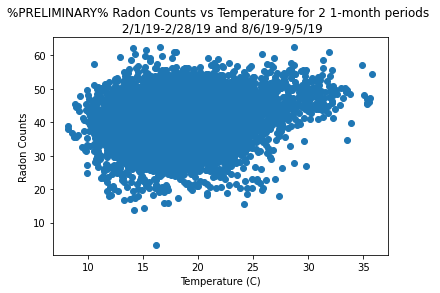

In [15]:
### Plotting radon counts vs temperature for the generated data set

import matplotlib.pyplot as mp
mp.scatter(DS_final['Temperature'],DS_final['Radon Counts'])
mp.title('%PRELIMINARY% Radon Counts vs Temperature for 2 1-month periods \n 2/1/19-2/28/19 and 8/6/19-9/5/19')
mp.xlabel('Temperature (C)')
mp.ylabel('Radon Counts')

## Stat Analysis

In [68]:
### Simple linear regression on the data set
import numpy as np

## Reading each column of data, and converting to a numpy array
x=DS_combined['Temperature'].to_numpy()
y=DS_combined['Radon Counts'].to_numpy()

## Calculating the mean of each array
xmean = np.mean(x)
ymean = np.mean(y)

## Calculating covariance
xycov = (x-xmean)*(y-ymean)
xvar = (x-xmean)**2

## Calculating regression coefficients
beta = xycov.sum()/xvar.sum()
alpha = ymean - (beta*xmean)
print('alpha =',alpha)
print('beta =',beta)

## Predicting y-values based on the model
ypred = alpha + beta*x

## Finding R^2 value for the data set
r = np.corrcoef(x,y)[0,1]
r_squared = r**2
r_squared

alpha = 39.11616856994754
beta = 0.08223618922020737


0.006465803048657293

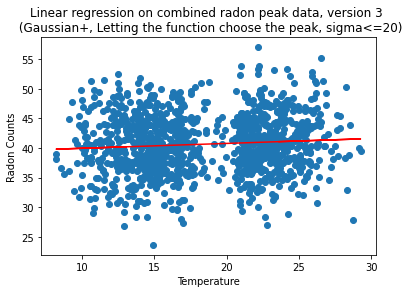

In [70]:
### Plotting regression model alonside original data

import matplotlib.pyplot as mp

mp.scatter(x,y)
mp.plot(x,ypred,color = 'red')
mp.xlabel('Temperature')
mp.ylabel('Radon Counts')
mp.title('Linear regression on combined radon peak data, version 3 \n (Gaussian+, Letting the function choose the peak, sigma<=20)')
mp.show()

$R^2$= 0.0029

# Finish here for the general notebook output (random unused cells below)

## Debugging

In [ ]:
### For testing an individual hour of data independently of the whole loop

import pandas as pd
from scipy.signal import find_peaks as fp
from scipy.optimize import curve_fit

test_hour = df_month.iloc[132:144,4::]
hour_totals = test_hour.sum(axis=0)
counts = hour_totals.to_numpy()
peaks,_ = fp(hour_totals,prominence = 25)
peaks

### Selecting the maximum value from appropriate range of indeces, and by extension finds the peak

peak_interval = np.where(np.logical_and(peaks<=275,peaks>=225)) #Collecting the indeces from "peaks" that fall over a given interval
temp = hour_totals.iloc[peaks[peak_interval[0]]] # selects the rows from the "hour" dataframe according to above line to compare count values
#if temp.shape[0]==0:
    #radon_count[i] = 0
    #continue
peak_214 = int(temp.idxmax(temp)) # Finds the index of the maximum on this interval, and therefore the peak
peak_214

### Setting the range that the peak should fall on
peak_start = peak_214 - 19
peak_end = peak_214 + 23

### Setting left and right bands, combining them, and selecting the appropriate channels from the count data
left_band = np.linspace(peak_start-60, peak_start, 61)
right_band = np.linspace(peak_end, peak_end+60, 61)
combined_band = np.concatenate([left_band,right_band])
band_counts = hour_totals.iloc[combined_band].to_numpy()

### Fitting the data to a polynomial, and generating interpolated data points to form a "background curve"
def func(x,a,b,c,d,e): 
    return a*x**4 + b*x**3 + c*x**2 + d*x + e #could be replaced with another type of function if better specificity is needed
popt,pcov = curve_fit(func,combined_band,band_counts)
popt
peak_range = np.linspace(peak_start-60,peak_end+60,163)
fitted_counts = func(peak_range,*popt) # generating the y-values for the interpolated curve
original_counts = hour.iloc[peak_start-60:peak_end+61,0] # providing original data values to plot the fit against

iso_fit = fitted_counts[60:-60] # Section of the fit curve that matches with the peak start and end points
iso_original = original_counts[60:-60] # Bi-214 peak from original data
iso_radon = iso_original - iso_fit # subtracting the generated background curve from the peak, to isolate the counts attributed to the peak

In [ ]:
import numpy
combined_band_2 = combined_band.astype(int)
combined_band_2

In [ ]:
import matplotlib.pyplot as mp
%matplotlib tk

mp.plot(counts)
mp.plot(peak_214,counts[peak_214],"x")
mp.yscale("log")
mp.xlabel('Channel #')
mp.ylabel('Counts')
mp.title('Counts vs channel for the 8am hour on 8/7/19')
mp.plot(peak_start,counts[peak_start],"x")
mp.plot(peak_end,counts[peak_end],"x")
#mp.plot(combined_band_2,counts[combined_band_2],"x")
mp.plot(peak_range,fitted_counts)

In [ ]:
import matplotlib.pyplot as mp
%matplotlib tk

mp.plot(channel_counts)
mp.title('Counts vs channel for the 8am hour on 8/7/19')
mp.yscale("log")
mp.xlabel('Channel #')
mp.ylabel('Counts')

## Plotting cells

In [ ]:
### Checking the spectrum from the input hour, and how good the system is at actually locating the peak
import matplotlib.pyplot as mp
%matplotlib inline

mp.plot(counts)
mp.yscale("log")
mp.plot(peak_214,counts[peak_214],"x")
mp.plot(peak_start,counts[peak_start],"x")
mp.plot(peak_end,counts[peak_end],"x")
mp.xlim(160,320)
mp.ylim(30,200)
mp.title('Spectrum for the first hour of data')
mp.xlabel('channel #')
mp.ylabel('Total counts')
mp.show()

In [ ]:
### Plotting the hourly spectrum, as well as the fit curve with it

import matplotlib.pyplot as mp

mp.plot(np.linspace(peak_start-60,peak_end+61,163),original_counts)
mp.plot(peak_range,fitted_counts)
mp.title('Interpolation of the background from left and right bands')
mp.xlabel('Channel #')
mp.ylabel('Counts')

## Code cells

In [ ]:
##### SIMPLE POLYNOMIAL FIT, NO GAUSSIAN COMPONENT


### Iteratively generating spectra, finding peaks, and totalling gamma counts attributed to radon, outputting a single value per hour
## May or may not be a good model, not sure at this point. Several steps could be taken to make it more complete, like searching 
## for the edges of the peaks, or doing a gaussian or similar fit to the peak and subtracting background from that.
## Part of the issue lies in the fact that the spectra are very noisy still, even though they are a combination of up to 12 data
## collections each.

# Note for improvement: use averages instead of sums to be able to ensure that the number of points collected in an hour is not 
# influencing the output

import pandas as pd
from scipy.signal import find_peaks as fp
import numpy as np
from scipy.optimize import curve_fit

### Creating a dataframe of exactly a month of collected data
col = ['deviceTime_utc','cpm','cpmError','1023','error_flag']
df_month = df_full[182138:190991].reset_index().drop(columns=col) # takes exactly a month, from 12:01 AM 8/6/19 to 11:59 PM 9/5/19 (local time)
radon_count = np.zeros(744)
start = 1565074800 # Setting a baseline time for the loop to start from (in this case it is 12:00:00 Local Time 8/6/19)
end = start

for i in range(0,24*31):
    # Will eventually become a for loop, with an iteration for each hour
    #start = df_month.at[i,'deviceTime_unix']-10 ####### change out the zero for the current for loop index
    #end = start + 3600
    start = end #setting start time based on current index
    end = start + 3600
    hour_set = df_month['deviceTime_unix'].between(start,end)
    hour = df_month[hour_set].drop(columns=['index','deviceTime_local','deviceTime_unix','keV_per_ch']).sum(axis=0)
    hour = pd.DataFrame({'Total Counts':hour})
    counts = hour['Total Counts'].to_numpy()
    peaks,_ = fp(counts,prominence = 25)
    if peaks.size == 0:
        print('No peak found. Iteration #',i) # If this prints, it means that there is no data for this hour, or it is incredibly skewed

    ### Selecting the maximum value from appropriate range of indeces, and by extension finds the peak

    peak_interval = np.where(np.logical_and(peaks<=275,peaks>=225)) #Collecting the indeces from "peaks" that fall over a given interval
    temp = hour.iloc[peaks[peak_interval[0]],0] # selects the rows from the "hour" dataframe according to above line to compare count values
    if temp.shape[0]==0:
        radon_count[i] = 0
        continue
    peak_214 = int(temp.idxmax(temp)) # Finds the index of the maximum on this interval, and therefore the peak

    ### Setting the range that the peak should fall on
    peak_start = peak_214 - 19
    peak_end = peak_214 + 23

    ### Setting left and right bands, combining them, and selecting the appropriate channels from the count data
    left_band = np.linspace(peak_start-60, peak_start, 61)
    right_band = np.linspace(peak_end, peak_end+60, 61)
    combined_band = np.concatenate([left_band,right_band])
    band_counts = hour.iloc[combined_band,0].to_numpy()

    ### Fitting the data to a polynomial, and generating interpolated data points to form a "background curve"
    def func(x,a,b,c,d,e): 
        return a*x**4 + b*x**3 + c*x**2 + d*x + e #could be replaced with another type of function if better specificity is needed
    popt,pcov = curve_fit(func,combined_band,band_counts)
    popt
    peak_range = np.linspace(peak_start-60,peak_end+60,163)
    fitted_counts = func(peak_range,*popt) # generating the y-values for the interpolated curve
    original_counts = hour.iloc[peak_start-60:peak_end+61,0] # providing original data values to plot the fit against

    ### Isolating the Bi-214 peak from the spectrum and summing
    iso_fit = fitted_counts[60:-60] # Section of the fit curve that matches with the peak start and end points
    iso_original = original_counts[60:-60] # Bi-214 peak from original data
    iso_radon = iso_original - iso_fit # subtracting the generated background curve from the peak, to isolate the counts attributed to the peak
    radon_count[i] = iso_radon.sum() # the total counts within the designated hour that are attributed to radon
    #if iso_radon.sum() < 0:
     #   radon_count[i] = 0

In [ ]:
### %Testing%, keeping here just in case

### Selecting the maximum value from appropriate range of indeces, and by extension finds the peak

peak_range = np.where(np.logical_and(peaks<=275,peaks>=225)) #Collecting the indeces from "peaks" that fall over a given interval
temp = hour.iloc[peaks[peak_range],0] #selects the rows from the "hour" dataframe according to above line to compare count values
peak_214 = int(temp.idxmax(temp)) # Finds the index of the maximum on this interval, and therefore the peak
c

In [ ]:
### %Testing% building the interpolated curve

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as mp

### Setting left and right bands, combining them, and selecting the appropriate channels from the count data
left_band = np.linspace(peak_start-60, peak_start, 61)
right_band = np.linspace(peak_end, peak_end+60, 61)
combined_band = np.concatenate([left_band,right_band])
band_counts = hour.iloc[combined_band,0].to_numpy()

def func(x,a,b,c,d,e): 
    return a*x**4 + b*x**3 + c*x**2 + d*x + e #could be replaced with another type of function if better specificity is needed
popt,pcov = curve_fit(func,combined_band,band_counts)
popt
fitted_counts = func(combined_band,*popt)
original_counts = hour.iloc[peak_start-60:peak_end+61,0]